# DOE 本番解析用 (base) v4

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [4]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## CSV ファイル一覧の取得

In [5]:
name_doe = "doe-10d"  # 実験計画名（フォルダ名）
# name_code = "7011"  # 銘柄コード
# name_code = "7203"  # 銘柄コード
name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
if m := pattern_date.match(file_last):
    date_dir = os.path.join(
        "..", "output", name_doe, f"y{m.group(1)}", m.group(2), m.group(3)
    )
    date_str = date_dir
else:
    date_dir = os.path.join("..", "output", name_doe, "y0000", "00", "00")
    date_str = date_dir
os.makedirs(date_dir, exist_ok=True)
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['result_20250819.csv', 'result_20250820.csv', 'result_20250821.csv', 'result_20250822.csv', 'result_20250825.csv', 'result_20250826.csv', 'result_20250827.csv', 'result_20250828.csv', 'result_20250829.csv', 'result_20250901.csv', 'result_20250902.csv', 'result_20250903.csv', 'result_20250904.csv', 'result_20250905.csv', 'result_20250908.csv', 'result_20250909.csv', 'result_20250910.csv', 'result_20250911.csv', 'result_20250912.csv', 'result_20250916.csv', 'result_20250917.csv', 'result_20250918.csv', 'result_20250919.csv', 'result_20250922.csv', 'result_20250924.csv', 'result_20250925.csv', 'result_20250926.csv', 'result_20250929.csv', 'result_20250930.csv', 'result_20251001.csv', 'result_20251002.csv', 'result_20251003.csv', 'result_20251006.csv', 'result_20251007.csv', 'result_20251008.csv', 'result_20251009.csv', 'result_20251010.csv', 'result_20251014.csv', 'result_20251015.csv', 'result_20251016.csv', 'result_20251017.csv', 'result_20251020.csv', 'result_20251

## CSV ファイルの読み込み、連結

In [6]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    df_tick = df_tick.astype({"total": float})
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "trade", "total"]
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = (
    df_latest.style.format({"取引回数": "{:d}", "損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_latest_single.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                    file  code  trade   total  PERIOD_MA_1  PERIOD_MA_2  \
0    ticks_20250819.xlsx  7203     62  3900.0           30          300   
1    ticks_20250819.xlsx  7203     32  3900.0           40          300   
2    ticks_20250819.xlsx  7203     22  3050.0           50          300   
3    ticks_20250819.xlsx  7203     24  3800.0           60          300   
4    ticks_20250819.xlsx  7203     22  4300.0           70          300   
..                   ...   ...    ...     ...          ...          ...   
284  ticks_20250819.xlsx  7203      6  -200.0          150         1100   
285  ticks_20250819.xlsx  7203      6   100.0          160         1100   
286  ticks_20250819.xlsx  7203      6   200.0          170         1100   
287  ticks_20250819.xlsx  7203      2  -600.0          180         1100   
288  ticks_20250819.xlsx  7203      2  -200.0          190         1100   

     TURBULENCE  
0            25  
1            25  
2            25  
3     

### 本日の条件

In [7]:
x_por = 60
y_por = 600
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
print(df_latest[(df_latest[col_x] == x_por) & (df_latest[col_y] == y_por)])

     PERIOD_MA_1  PERIOD_MA_2  取引回数     損益 備考
105           60          600    14  700.0   


## 最終日のデータだけで作成した等高線図

In [8]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

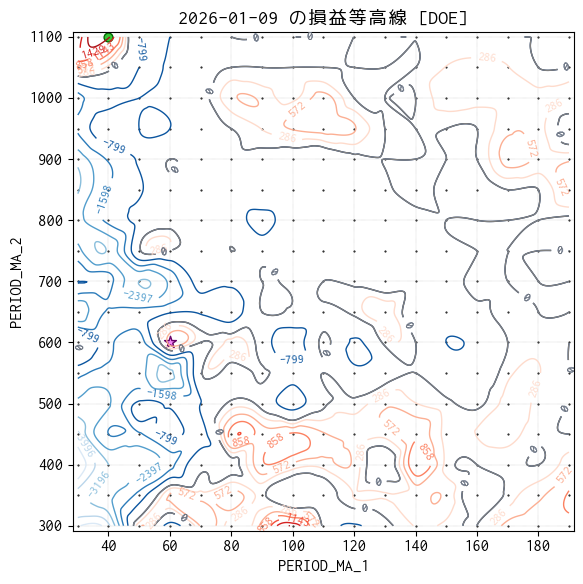

In [9]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [DOE]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = os.path.join(date_str, f"{name_code}_contour_single.png")

# plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
# plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

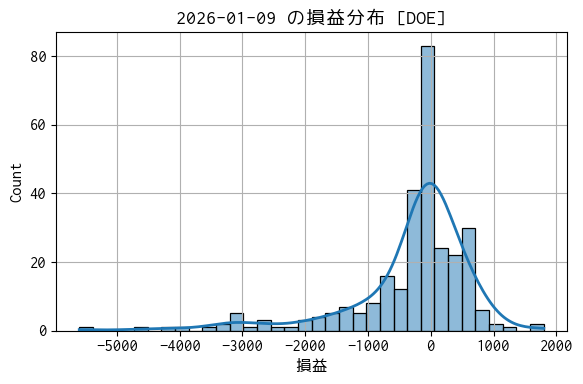

In [10]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [DOE]")

plt.tight_layout()
output = os.path.join(date_str, f"{name_code}_hist_single.png")
plt.savefig(output)
plt.show()

## 最大・最小損益（ヒストリカル）

In [11]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高損益")
print(df[df["total"] == total_max])
print("\n最低損益")
print(df[df["total"] == total_min])

最高損益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2  \
15312  ticks_20251105.xlsx  7203     14  13800.0          150         1100   

       TURBULENCE  
15312          25  

最低損益
                      file  code  trade    total  PERIOD_MA_1  PERIOD_MA_2  \
15032  ticks_20251105.xlsx  7203    100 -23000.0           70          300   

       TURBULENCE  
15032          25  


## サマリ統計の算出

In [12]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values(["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True)
print("サマリ統計")
print(df_summary)

# HTML 形式で出力
styled = (
    df_summary.style.format({"trade": "{:.0f}", "total": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)

html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_summary.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計
     PERIOD_MA_1  PERIOD_MA_2      trade       total
0             30          300  70.083333 -859.895833
1             40          300  48.916667 -317.187500
2             50          300  30.666667 -113.020833
3             60          300  23.583333 -181.250000
4             70          300  17.625000 -208.333333
..           ...          ...        ...         ...
284          150         1100   2.708333   89.583333
285          160         1100   2.541667   91.666667
286          170         1100   2.333333   58.854167
287          180         1100   2.062500   -1.041667
288          190         1100   1.854167   25.000000

[289 rows x 4 columns]


## 日付 × 条件 で損益を集計

In [13]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で損益")
df_raw = df_raw.astype("float64")
print(df_raw)


df_raw: 日付 x 条件で損益
               0       1       2       3       4       5       6       7    \
2025-08-19  3900.0  3900.0  3050.0  3800.0  4300.0  4000.0  1700.0  1500.0   
2025-08-20  2950.0  4000.0  4950.0  3100.0  1050.0  1250.0   800.0  1250.0   
2025-08-21 -1400.0  -750.0  -800.0   650.0   600.0  -500.0  -500.0  -350.0   
2025-08-22  1700.0  1450.0  1400.0   550.0   100.0   350.0  -100.0   -50.0   
2025-08-25  -950.0  -150.0  -350.0   400.0   300.0   350.0  4050.0     0.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-05 -2600.0 -3400.0 -4400.0 -1300.0  -800.0   300.0   200.0   100.0   
2026-01-06  -700.0 -1900.0   700.0  2100.0 -1500.0 -2100.0  -300.0 -1400.0   
2026-01-07  1500.0     0.0   400.0 -1600.0   600.0     0.0   400.0   400.0   
2026-01-08 -3000.0 -5100.0 -2100.0  -900.0  -200.0  -500.0 -1000.0  -500.0   
2026-01-09 -4700.0 -4200.0   500.0 -1100.0   600.0   100.0   700.0  1700.0   

               8       9    ...     279    

## 平均損益の算出

In [14]:
df_mean = df_raw.copy()
# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均損益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均損益（逆ソート後）")
print(ser_ranking)

データスコープを示す文字列
トヨタ自動車 (7203) from 2025-08-19 to 2026-01-09, n = 96 days

df_mean: 新しい日付から古い日付と逆順に平均損益を算出
                    0            1            2            3            4    \
2025-08-19  3900.000000  3900.000000  3050.000000  3800.000000  4300.000000   
2025-08-20  3425.000000  3950.000000  4000.000000  3450.000000  2675.000000   
2025-08-21  1816.666667  2383.333333  2400.000000  2516.666667  1983.333333   
2025-08-22  1787.500000  2150.000000  2150.000000  2025.000000  1512.500000   
2025-08-25  1240.000000  1690.000000  1650.000000  1700.000000  1270.000000   
...                 ...          ...          ...          ...          ...   
2026-01-05  -822.282609  -209.239130  -112.500000  -172.826087  -211.956522   
2026-01-06  -820.967742  -227.419355  -103.763441  -148.387097  -225.806452   
2026-01-07  -796.276596  -225.000000   -98.404255  -163.829787  -217.021277   
2026-01-08  -819.473684  -276.315789  -119.473684  -171.578947  -216.842105   
2026-01-09  -859.895833  -3

### 検算

In [15]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均損益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## 今日（最終データ）のベスト損益

In [16]:
dt_last = df_raw.index[-1]
df_raw_last = df_raw.loc[str(dt_last.date())]
total_last_max = df_raw_last.max()
colname_last_best = df_raw_last[df_raw_last == total_last_max].index[0]

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "total"]
df_last_max = pd.DataFrame(df_summary.loc[colname_last_best][list_col]).T.copy()
df_last_max.loc[colname_last_best, "total"] = total_last_max
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "損益"]
df_last_max.columns = list_col_new
print(f"最終日 ({dt_last.date()}) の最高損益条件")
print(df_last_max)

最終日 (2026-01-09) の最高損益条件
     PERIOD_MA_1  PERIOD_MA_2      損益
273         40.0       1100.0  1800.0


## ランキング

In [17]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_best.columns = list_col

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = (
    df_best.style.format({"取引回数": "{:.0f}", "平均損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_negative.columns = list_col

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2      取引回数        平均損益
65           170          450  2.479167  296.354167
64           160          450  2.979167  255.208333
279          100         1100  5.687500  252.604167
180          130          800  4.104167  235.937500
210           90          900  7.062500  211.458333
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2       取引回数         平均損益
287          180         1100   2.062500    -1.041667
185          180          800   2.250000    -1.562500
110          110          600   5.416667    -2.083333
220          190          900   2.166667    -4.166667
146          130          700   3.791667    -5.729167
..           ...          ...        ...          ...
85            30          550  60.562500 -1104.687500
51            30          450  62.791667 -1126.562500
34            30          400  65.875000 -1134.895833
68            30          500  63.208333 -1163.020833
17            30          350  70.041667 -1223.9583

## 実験条件毎の損益トレンド

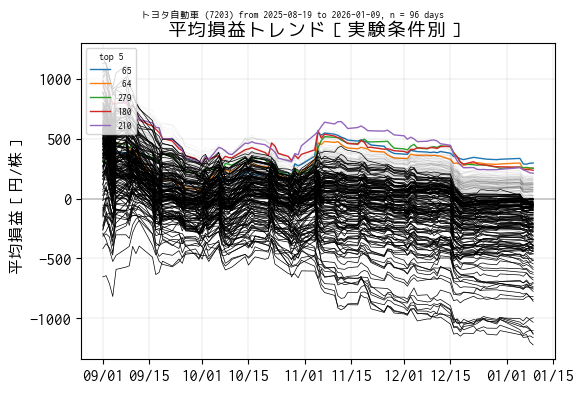

In [18]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均損益［円/株］")
ax.set_title("平均損益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_mean_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ損益条件 (mean) の日別損益トレンド

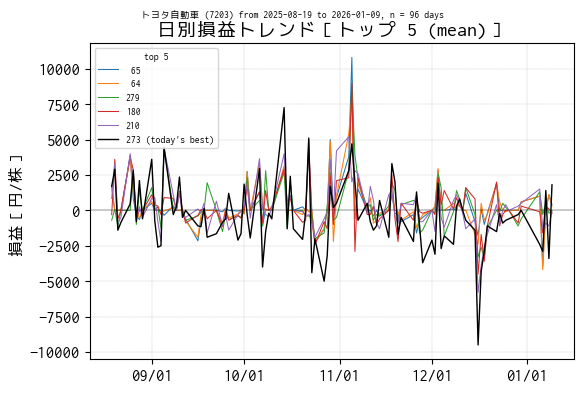

In [19]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title("日別損益トレンド［トップ 5 (mean)］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})
output = os.path.join(date_str, f"{name_code}_trend_daily_profit_1.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

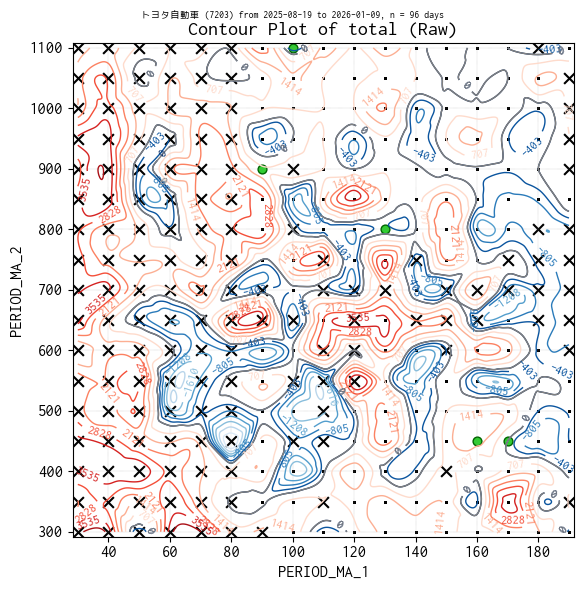

In [20]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
# cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
# ax.clabel(cont, inline=True, fontsize=9)

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
output = os.path.join(date_str, f"{name_code}_raw_contour_{target}.png")
plt.savefig(output)
plt.show()

## メディアン損益の算出

In [21]:
df_median = df_raw.copy()
# データスコープを示す文字列
dt_start = df_median.index[0]
dt_end = df_median.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

データスコープを示す文字列
トヨタ自動車 (7203) from 2025-08-19 to 2026-01-09, n = 96 days


In [22]:
n = len(df_median.index)

In [23]:
df_median[:n].median()

0     -750.0
1     -125.0
2      100.0
3        0.0
4        0.0
       ...  
284      0.0
285      0.0
286      0.0
287      0.0
288      0.0
Length: 289, dtype: float64

In [24]:
# メディアン損益の算出
n = len(df_median.index)
while n > 0:
    # 最下行から順にメディアンを算出して、行の内容を置換。
    df_median.iloc[n - 1] = df_median[:n].median()
    n -= 1
print("\ndf_median: 新しい日付から古い日付と逆順にメディアン損益を算出")
print(df_median)

# 最終日の損益収益のランキング
ser_ranking = df_median.iloc[len(df_median) - 1].sort_values(ascending=False)
print("最新のメディアン損益（逆ソート後）")
print(ser_ranking)


df_median: 新しい日付から古い日付と逆順にメディアン損益を算出
               0       1       2       3       4       5       6       7    \
2025-08-19  3900.0  3900.0  3050.0  3800.0  4300.0  4000.0  1700.0  1500.0   
2025-08-20  3425.0  3950.0  4000.0  3450.0  2675.0  2625.0  1250.0  1375.0   
2025-08-21  2950.0  3900.0  3050.0  3100.0  1050.0  1250.0   800.0  1250.0   
2025-08-22  2325.0  2675.0  2225.0  1875.0   825.0   800.0   350.0   600.0   
2025-08-25  1700.0  1450.0  1400.0   650.0   600.0   350.0   800.0     0.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-05  -750.0  -100.0   100.0    25.0     0.0     0.0     0.0     0.0   
2026-01-06  -750.0  -100.0   100.0    50.0     0.0     0.0     0.0     0.0   
2026-01-07  -725.0  -100.0   100.0    25.0     0.0     0.0     0.0     0.0   
2026-01-08  -750.0  -100.0   100.0     0.0     0.0     0.0     0.0     0.0   
2026-01-09  -750.0  -125.0   100.0     0.0     0.0     0.0     0.0     0.0   

              8       9  

## サマリ統計（メディアン）

In [25]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答のメディアンを集計（サマリデータ）
df_summary_2 = df.groupby(factor_cols)[response_cols].median().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary_2 = df_summary_2.sort_values(
    ["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True
)
print("サマリ統計（メディアン）")
print(df_summary_2)

サマリ統計（メディアン）
     PERIOD_MA_1  PERIOD_MA_2  trade  total
0             30          300   68.0 -750.0
1             40          300   44.0 -125.0
2             50          300   26.0  100.0
3             60          300   20.0    0.0
4             70          300   14.0    0.0
..           ...          ...    ...    ...
284          150         1100    2.0    0.0
285          160         1100    2.0    0.0
286          170         1100    2.0    0.0
287          180         1100    2.0    0.0
288          190         1100    1.0    0.0

[289 rows x 4 columns]


### 検算

In [26]:
"""
サマリ統計 (df_summary) の平均値と、算出したメジアン損益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary_2["total"] - df_median.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング (2)

In [27]:
# トップランキング
n_top = 10
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary_2.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_best.columns = list_col

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = (
    df_best.style.format({"取引回数": "{:.0f}", "メジアン損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best_median.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary_2.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_negative.columns = list_col

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益
23            90          350   8.0   150.0
24           100          350   6.0   100.0
2             50          300  26.0   100.0
41           100          400   6.0    75.0
40            90          400   8.0    25.0
267          150         1050   2.0     0.0
268          160         1050   2.0     0.0
269          170         1050   2.0     0.0
264          120         1050   4.0     0.0
263          110         1050   4.0     0.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益
161          110          750   4.0   -25.0
76           110          500   4.0   -25.0
178          110          800   4.0   -50.0
55            70          450  12.0   -50.0
210           90          900   6.0   -50.0
..           ...          ...   ...     ...
204           30          900  46.0 -1000.0
272           30         1100  42.0 -1000.0
34            30          400  64.0 -1000.0
119           30          650  54

## 実験条件毎の収益トレンド（メジアン）

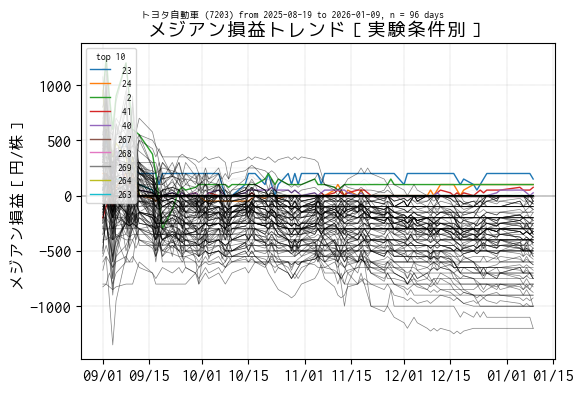

In [28]:
# ---------------------------------------------------------
# 実験条件毎のメジアン損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_median[dt_from <= df_median.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(
            df_trend[colname],
            linewidth=0.5,
            linestyle="solid",
            color="black",
            alpha=0.5,
        )
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("メジアン損益［円/株］")
ax.set_title("メジアン損益トレンド［実験条件別］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_median_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ収益条件 (median) の日別損益トレンド

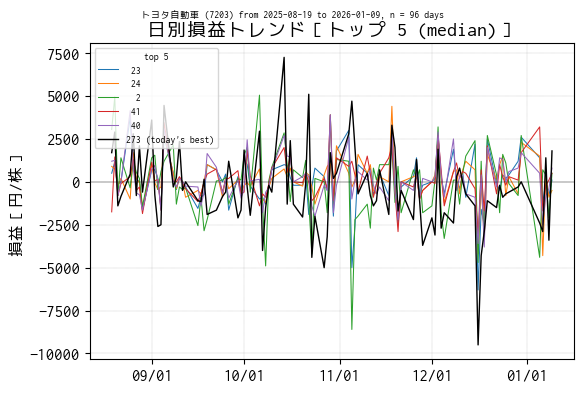

In [29]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title("日別損益トレンド［トップ 5 (median)］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title("top 5", prop={"size": 7})
output = os.path.join(date_str, f"{name_code}_trend_daily_profit_2.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()